# Check adversarial examples created in verification process

In [1]:
import os
os.chdir('../')
import torch
import numpy as np
import plotly.graph_objects as go
import torchvision
import torchvision.transforms as transforms
import PIL.Image as Image
from model_defs import *
import pickle
import io
import matplotlib.pyplot as plt

/usr/local/anaconda3/envs/alpha-beta-crown/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/anaconda3/envs/alpha-beta-crown/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/usr/local/anaconda3/envs/alpha-beta-crown/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b)
  Referenced from: '/usr/local/anaconda3/envs/alpha-beta-crown/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/usr/local/anaconda3/envs/alpha-beta-crown/lib/python3.10/site-packages/torch/lib/libc10.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. 

In [2]:
# For unpickling files written on machine with GPU
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
def classify_tensor(model, x, classes, name = None, silent = False):
    model = model.eval()
    output = model(x.unsqueeze(0))
    _,predicted = torch.max(output.data, 1)
    cl = predicted.item()
    probs = torch.nn.functional.softmax(output[0], dim = 0).detach()
    if not silent:
        if name is not None:
            print("Predicted class ("+name+"): "+str(classes[cl])+ " ("+str(cl)+")\n")
        else:
            print("Predicted class: "+str(classes[cl])+ " ("+str(cl)+")\n")
        for i, c in enumerate(classes):
            print(f'{probs[i]*100:.2f}% {c}')
        print('\n')

    return cl, probs[cl].item()

In [4]:
### CIFAR10 specific stuff
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

def denormalise(image, mean, std):
    #image comes in with shape (32, 32, 3)
    return torch.Tensor(std) * image + torch.Tensor(mean)


### Load model weights and saved adversarial examples:

In [16]:
orig_model_weights_path = 'CNN-B_CIFAR10/Pretrained/Models/cnn_b_2_255_cifar10_baseline.pth'
graft_model_weights_path = 'CNN-B_CIFAR10/Pretrained/Models/cnn_b_2_255_cifar10_graft.pth'

model_paths = {'Original':orig_model_weights_path, 'Graft': graft_model_weights_path}

orig_adv_examples_path = "VERIFY/CNN-B Example/Baseline/adv_examples.pkl"
graft_adv_examples_path = "VERIFY/CNN-B Example/Grafted/adv_examples.pkl"

adv_paths = {'Original':orig_adv_examples_path, 'Graft': graft_adv_examples_path}

In [17]:
model_name = "Graft"
# adjust architecture accordingly
#model = cifar_cnn_b()
model = cifar_cnn_b_graft()
# choose which adversarial examples to use (created either on original or grafted model)
adv_name = "Original"


In [18]:
model_weights_path = model_paths[model_name]
weights = torch.load(model_weights_path, map_location=torch.device('cpu'))
model.load_state_dict(weights)
#uncomment depending on model
#model.load_state_dict(weights['state_dict'])

adv_examples_path = adv_paths[adv_name]
with open(adv_examples_path, 'rb') as handle:
    adv_examples = CPU_Unpickler(handle).load()

### Adversarial examples are saved in a dictionary with the keys being the indices of the images in the test set

In [19]:
print(adv_examples.keys())

dict_keys([5, 12, 20, 22, 26, 28, 31, 32, 36, 37, 42, 65, 68, 69, 70, 74, 76, 86, 95, 100, 106, 121, 125, 126, 128, 147, 151, 153, 158, 162, 168, 171, 176, 177, 183, 187, 190, 192, 195, 201, 214, 223, 229, 232, 242, 253, 255, 256, 269, 270, 273, 275, 278, 286, 293, 295, 303, 308, 313, 314, 319, 343, 346, 352, 354, 355, 357, 366, 370, 373, 376, 377, 383, 384, 388, 391, 394, 398, 403, 405, 412, 418, 430, 432, 435, 436, 441, 444, 446, 457, 458, 465, 467, 474, 476, 479, 485, 491, 503, 513, 515, 524, 525, 528, 531, 532, 537, 548, 550, 562, 564, 585, 597, 599, 607, 617, 618, 629, 637, 646, 647, 652, 653, 657, 661, 668, 674, 682, 684, 686, 690, 692, 695, 701, 702, 703, 704, 706, 716, 717, 720, 727, 728, 730, 733, 760, 761, 767, 773, 775, 783, 788, 792, 794, 798, 799, 804, 810, 814, 819, 820, 821, 833, 834, 841, 843, 850, 867, 870, 877, 878, 881, 886, 889, 905, 910, 912, 919, 923, 924, 929, 930, 936, 941, 964, 965, 967, 970, 972, 974, 980, 981, 986, 995])


### Choose one index and examine the data saved in the verification process: original class & attacked class

In [21]:
index = 5
example = adv_examples[index]
print(f'ID: {example["ID"]}')
print(f'class: {classes[example["y"]]} ({example["y"]})')
print(f'attack target class: {classes[example["attack_label"]]} ({example["attack_label"]})')

ID: 5
class: frog (6)
attack target class: cat (3)


### Check if we can reproduce this when classifying both the original and attacked image with our model:

In [22]:
x = example['x']
attack_image = example['attack_image']
c_o, cert_o = classify_tensor(model, x, classes, name = 'original')
c_a, cert_a = classify_tensor(model, attack_image, classes, name = 'attack')

Predicted class (original): frog (6)

0.65% airplane
0.10% automobile
6.00% bird
10.34% cat
10.74% deer
7.90% dog
62.37% frog
1.63% horse
0.15% ship
0.13% truck


Predicted class (attack): frog (6)

0.89% airplane
0.11% automobile
6.91% bird
13.29% cat
13.18% deer
9.72% dog
53.31% frog
2.24% horse
0.19% ship
0.16% truck




### Visualise results

WARNING  15:38:43     Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


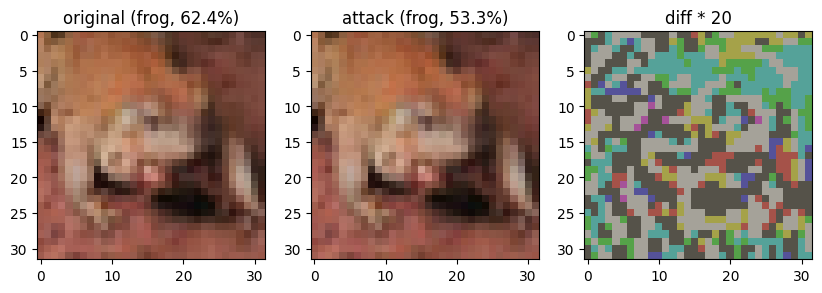

In [23]:
diff_scale = 20
_, axarr = plt.subplots(1,3, figsize = (10, 30))
axarr[0].imshow(denormalise(x.permute(1,2,0), mean, std))
axarr[0].set_title(f"original ({classes[c_o]}, {cert_o*100:.1f}%)")
axarr[1].imshow(denormalise(attack_image.permute(1,2,0), mean, std))
axarr[1].set_title(f"attack ({classes[c_a]}, {cert_a*100:.1f}%)")
axarr[2].imshow(denormalise((diff_scale*(x-attack_image)).permute(1,2,0), mean, std))
axarr[2].set_title(f'diff * {diff_scale}')
plt.show()

### Check property for all saved adversarial examples

In [24]:
num_res_equal = 0
num_also_adv = 0
num_not_adv = 0
num_mis_orig = 0
num_turned_around = 0
cert_os = []
cert_as = []

for _,example in adv_examples.items():
    x = example['x']
    attack_image = example['attack_image']
    c_o, cert_o = classify_tensor(model, x, classes, 'original', silent = True)
    c_a, cert_a = classify_tensor(model, attack_image, classes, 'attack', silent = True)
    cert_os.append(cert_o)
    cert_as.append(cert_a)
    if (c_o == example['y']) and (c_a == example['attack_label']):
        num_res_equal += 1
    if (c_o == example['y']) and (c_a not in [example['attack_label'], example['y']]):
        num_also_adv += 1
    if (c_o == example['y']) and (c_a == example['y']):
        num_not_adv += 1
    if (c_o != example['y']):
        num_mis_orig += 1
        if (c_a == example['y']):
            num_turned_around += 1

print(f'Number of tested adversarial examples: {len(cert_os)}')
print(f'Number of misclassified corresponding original images: {num_mis_orig}')
print(f'Number of turned around images: {num_turned_around}')
print(f'Number of not working adversarial examples: {num_not_adv}')
print(f'Number of working adversarial examples with equal target class: {num_res_equal}')
print(f'Number of working adversarial examples with different target class: {num_also_adv}')

print(f'All classification results equal to saved results: {num_res_equal == len(cert_os)}')
if num_res_equal == len(cert_os):
    print(f'Original classification certainty: \n\tmean: {np.mean(cert_os)*100:.1f}%\n\tstd: {np.std(cert_os)*100:.1f}%P')
    print(f'Attacked classification certainty: \n\tmean: {np.mean(cert_as)*100:.1f}%\n\tstd: {np.std(cert_as)*100:.1f}%P')
        

Number of tested adversarial examples: 194
Number of misclassified corresponding original images: 75
Number of turned around images: 0
Number of not working adversarial examples: 85
Number of working adversarial examples with equal target class: 30
Number of working adversarial examples with different target class: 4
All classification results equal to saved results: False


/var/folders/z5/yqd1shk93k5750y70gcq3tgw0000gn/T/ipykernel_22695/495151226.py:15: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



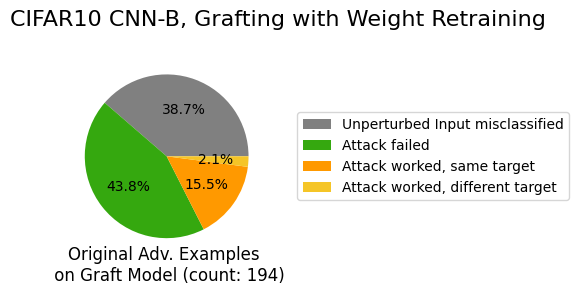

In [25]:
fig, ax = plt.subplots(figsize = (6, 3))
data = [num_mis_orig, num_not_adv, num_res_equal, num_also_adv]
colors = ['grey', '#35a80f', '#ff9900', '#f5c527']
labels = ["Unperturbed Input misclassified", "Attack failed", "Attack worked, same target", "Attack worked, different target"]
patches, texts, _ = ax.pie(data, colors = colors, autopct = '%1.1f%%')

ax.set_title(f"{adv_name} Adv. Examples \n on {model_name} Model (count: {len(cert_os)})", y=-0.15)
ax.legend(patches, labels, bbox_to_anchor=(2.5,0.5), loc="center right")



fig.suptitle('CIFAR10 CNN-B, Grafting with Weight Retraining', horizontalalignment = "center", fontsize = 16)
fig.tight_layout()
fig.savefig('graphics/test_advexpie.pdf', bbox_inches="tight")
fig.show()

In [26]:
labels = ['attacked samples', 'original classified correctly', 'original misclassified', 'attack successful', 'attack unsuccessful', 'equal target class', 'different target class']
source_list = [0, 0, 1, 1, 3, 3]
target_list = [1, 2, 3, 4, 5, 6]
val_list = [len(cert_os)-num_mis_orig, num_mis_orig, num_res_equal+num_also_adv, num_not_adv, num_res_equal, num_also_adv]

In [27]:
colors = ['blue', 'blue', 'grey', 'blue', 'darkorange', 'green', 'lightgreen']
link_colors = [colors[target_list[i]] for i in range(len(target_list))]
fig = go.Figure(data=[go.Sankey(
    #textfont=dict(color="rgba(0,0,0,0)", size=1),
    #arrangement = "fixed",
    node = dict(
      pad = 10,
      thickness = 20,
    #   x=[0.15, 0.15, 0.15, 0.15, 0.8, 0.8, 0.8, 0.8],
    #   y = pos_list,
      line = dict(color = "White", width = 0.5),
      label = labels,
      color =  colors*2
    ),
    link = dict(
      #arrowlen = 2,
      line = dict(color = "White", width = 0.5),
      source = source_list,
      target = target_list,
      value = val_list,
      color = link_colors
  ))])

fig.update_layout(title_text=f"{adv_name} adv examples evaluated on {model_name} model \
  <br><sup>{(num_res_equal+num_also_adv)/len(cert_os)*100:.1f}% of samples remain adversarial examples \
    <br>{((num_res_equal+num_also_adv)/(len(cert_os)-num_mis_orig))*100:.1f}% of correctly classified samples remain adversarial examples \
      <br>{model_name} model robust to {num_not_adv/len(cert_os)*100:.1f}% of {adv_name} adv examples</sup>", font_size=15, paper_bgcolor='#F8F8ff')
fig.show()



